# 1. 门控循环单元GRU

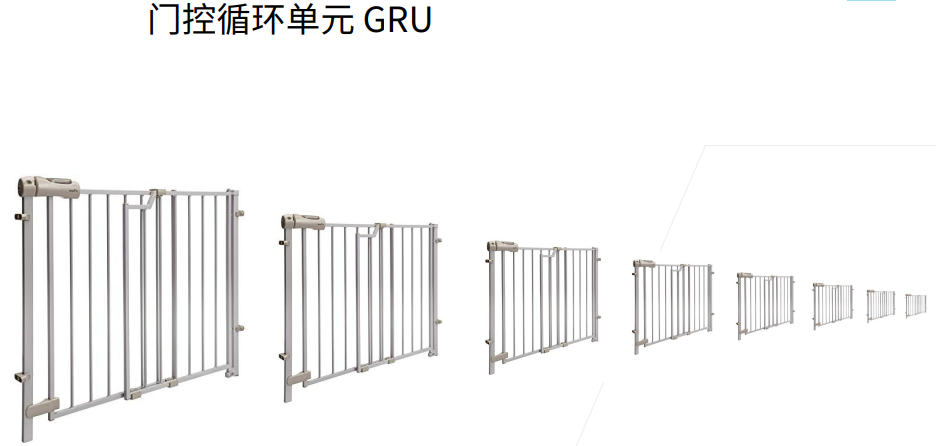

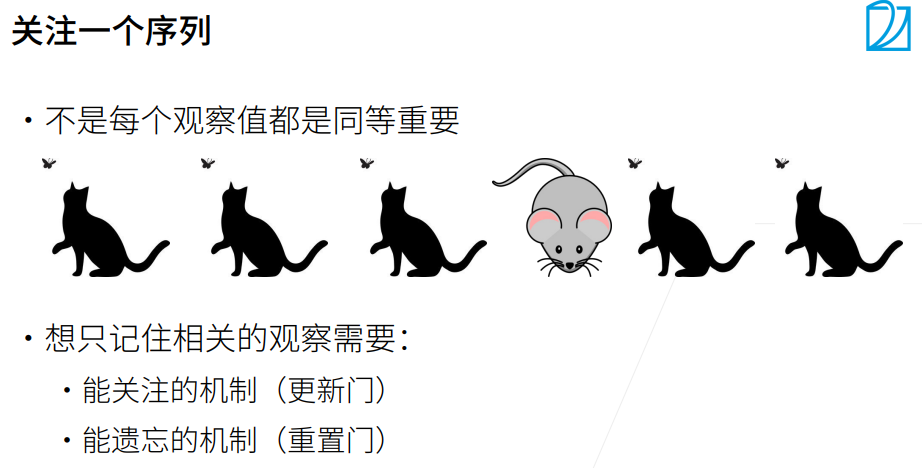

① 相当于全连接层把X和H并在一起。（$R_t$和$Z_t$分别使用不同的参数）

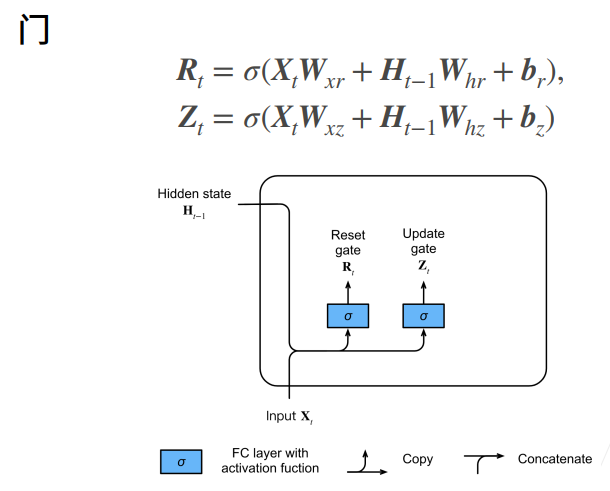

② 点圈是按元素乘法的意思。

③ $R_{t}$是可以学的，它可以根据前面的信息，看到这种情况知道哪些东西pass到下面的情况，哪些东西不pass到下面的情况。
$\tilde{H_t}$是候选隐状态，也是隐状态$H_t$的组成部分之一。

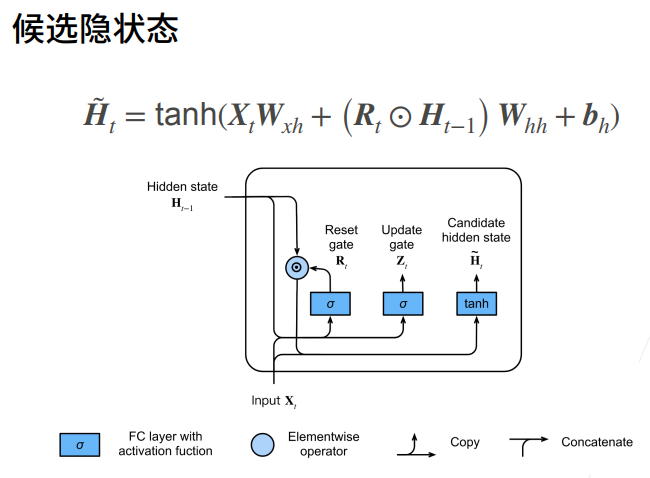

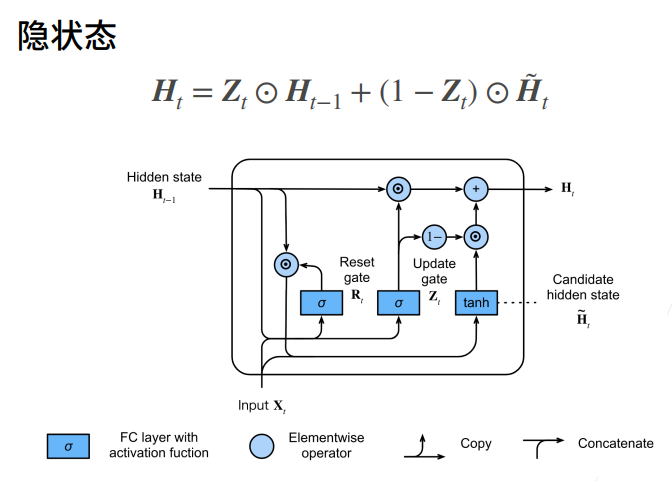

④ 更新新隐藏状态的时候，要用到多少过去隐藏状态的信息。

⑤ R和Z的不同取值：
+ 若Z全0，R全1：则会回到RNN状态。 
+ 若Z全0，R全0：则完全看当前输入$X_t$，不看过去的状态$H_{t-1}$。 
+ 若Z全1，与R无关了：则完全看过去的状态$H_{t-1}$，不看当前输入$X_t$。 

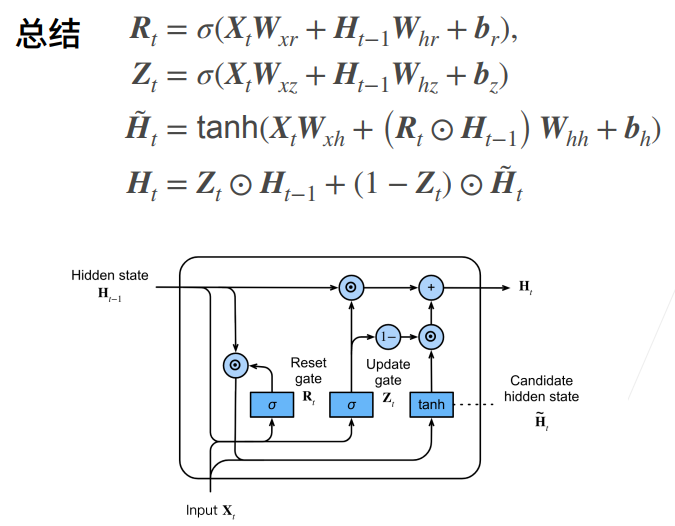

# 2. 门控循环单元GRU

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [3]:
# 初始化模型参数
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size
    
    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01
    
    # 获得两个W和一个b，共三个参数
    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))
    
    W_xz, W_hz, b_z = three()  # GRU多了这两行，Z_t
    W_xr, W_hr, b_r = three()  # GRU多了这两行，R_t
    
    W_xh, W_hh, b_h = three()
    
    # 输出层的参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]  # 共9+2=11个参数
    
    for param in params:
        param.requires_grad_(True)
    
    return params

In [4]:
# 定义隐藏状态的初始化函数
# 因为零时刻时没有上一刻的隐藏状态，所以要初始化隐藏状态
def init_gru_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),)

In [6]:
# 定义门控循环单元模型
def gru(inputs, state, params):
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params     
    H, = state
    outputs = []
    
    # 我们前面做了转置，将时间步放在了前面；
    # 所以这里对inputs做遍历时，相当于就可以分别取出大小为batch_size的第0步的数据、第1步的数据、第2步的数据……
    # 也即每个X的大小为batch_size*num_inputs
    for X in inputs:
        Z = torch.sigmoid((X @ W_xz) + (H @ W_hz) + b_z)  # 其中"@"表示做矩阵乘法，和torch.mm之类的是类似的
        R = torch.sigmoid((X @ W_xr) + (H @ W_hr) + b_r)
        
        H_tilda = torch.tanh((X @ W_xh) + ((R * H) @ W_hh) + b_h)  # 其中"*"为点乘（哈达玛积）
        
        H = Z * H + (1 - Z) * H_tilda
        
        Y = H @ W_hq + b_q
        
        # 把每个输出放进outputs之中
        outputs.append(Y)
    
    return torch.cat(outputs, dim=0), (H,)

perplexity 1.1, 18580.3 tokens/sec on cuda:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


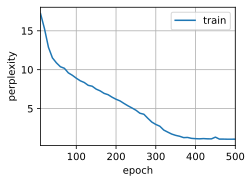

In [7]:
# 训练
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1

# 这里是GRU模型
# 因为RNNModelScratch设计的足够通用：所以用我们自定义的get_params, init_gru_state, gru三个函数传进去，就变成GRU模型了
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device,
                            get_params, init_gru_state, gru)

d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

perplexity 1.0, 124530.2 tokens/sec on cuda:0
time traveller with a slight accession ofcheerfulness really thi
travelleryou can show black is white by argument said filby


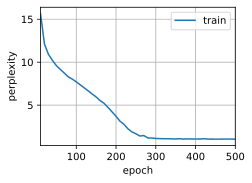

In [8]:
# 简洁实现
num_inputs = vocab_size
# 使用nn.GRU来构建GRU模型
gru_layer = nn.GRU(num_inputs, num_hiddens)

model = d2l.RNNModel(gru_layer, len(vocab))
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)